In [1]:
# CIS 545





# Homework 3, Part 2: PageRank (75 Points)

## Section 1: Computing PageRank (35 points)

For this part of the homework, you will use Jupyter on your local machine to understand and analyze graphs, first using some basic NetworkX packages and then by implementing matrix-based PageRank. 

After calculating PageRank for a large graph, you will explore how PageRank is affected by adding and deleting certain links in the graph and will gain insight into connectivity.


Recall that PageRank can be modeled using matrix operations as follows.  Let $M$ be a _weight transfer matrix_ in which:

$M[i,j] = \frac{1}{n_j}$, if $n_j > 0$ and 

$M[i,j] = 0$ otherwise

where page $i$ is pointed to by page $j$ and page $j$ has $n_j$ outgoing links. And define a _dampening factor_ $\alpha = 0.85$ and a corresponding $\beta = 1 - \alpha$.  Initialize the PageRank vector

$PR^{(0)}=[1,1,1,\ldots]^T$

(i.e., a matrix with m rows by 1 column, filled with ones).  Then we can compute the PageRank $PR$ for each iteration as:

$PR^{(i)}= \alpha \cdot M \cdot PR^{(i-1)} + \beta \cdot [1,1,1,\ldots]^T$

In [2]:
# [hw3-pad]
# This cell is for grading purposes only!
# "score" cells you may ignore, please don't interpret them as your grade!

score = 0 # for manual grading

print("[CIS 545 Homework 3] Test Case Padding")

[CIS 545 Homework 3] Test Case Padding


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Step 2.1 Download a web graph and store in a dataframe
The following code retrieves a web graph from https://snap.stanford.edu/data/web-NotreDame.txt.gz, which is a reasonably sized Web crawl done by Notre Dame University, and extracts it into `web-NotreDame.txt`.  Run the program to acquire your Web graph.


In [4]:
# Download and decompress data into your Jupyter environment
# Note this dataset is the same as the one Homework 3-1!

import urllib.request
import io
import gzip


for file in ['web-NotreDame.txt']:
    print ('Downloading compressed image of', file)
    source = urllib.request.urlopen("https://snap.stanford.edu/data/" + file + ".gz")
    compressedFile = io.BytesIO(source.read())
    decompressedFile = gzip.GzipFile(fileobj=compressedFile)

    with open(file, 'wb') as outfile:
        outfile.write(decompressedFile.read())
        outfile.close()
        print ('Saved', file)

Saved web-NotreDame.txt


Next, write Python code to take the data from `web-NotreDame.txt`, and read and parse the rows in a Pandas DataFrame (not a Spark DataFrame!) called `graph_df`.  Restrict the node IDs to values less than 5,000.  You will see that the resulting dataset is still quite large (16,665 rows).

**Hint**: If you use_ `read_csv`_, you may need to look at the_ `sep` _and_ `skiprows` _options.  Also take a look at the raw data and make sure you know how many rows don't contain data, and how the items are separated.  

In [5]:
pd.read_csv?

In [6]:
# [hw3-readcsv]
# TODO: In this cell, store the data from web-NotreDame.txt 
# in a dataframe called graph_df. 
# Note this is NOT 'graph_sdf' (we aren't using Spark!)
# (5 points)

graph_df = pd.read_csv('web-NotreDame.txt', sep='\t', skiprows=3)
graph_df.columns=['FromNodeId','ToNodeId']
graph_df = graph_df[(graph_df['FromNodeId']<5000) & (graph_df['ToNodeId']<5000)]
#len(graph_df)
graph_df.head(20)

,FromNodeId,ToNodeId
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
5,0,5
6,0,6
7,0,7
8,0,8
9,0,9


In [7]:
# [test-graphset]
# [CIS 545 Homework 3] Test Case

if (graph_df.shape[1] != 2):
    raise ValueError('Incorrect number of columns')

In [8]:
# [CIS 545 Test Cases] (0 pts)
print("[CIS 545 Homework 3] Test Case - 0 points")
score = score + 0

[CIS 545 Homework 3] Test Case - 0 points


In [9]:
# [test-graphshape]
# [CIS 545 Homework 3] Test Case


In [10]:
# [CIS 545 Test Cases] (5 pts)
print("[CIS 545 Homework 3] Test Case - 5 points")
score = score + 5

[CIS 545 Homework 3] Test Case - 5 points


### Step 2.2 Load the web graph into a matrix

We will now return to `graph_df` and use it to create a __weight transfer matrix M__, with edges whose weights are scaled as desribed at the beginning of this homework.  This will used as input to your PageRank algorithm.  Note that the dataset already includes node IDs that go from $0,\ldots,m$, so you can directly use the node IDs as indices in your matrix.  You should not use for loops, and instead, use the DataFrame and array functions that Pandas and NumPy provide as they are much more efficient.

When building $M$, you may need to build some "auxiliary" data structures to speed up performance, e.g., to quickly look up weights associated with node edges.  Note that lookup in an array is typically faster than lookup in a DataFrame.  Finally, you might want to use the_ `apply` _function for Pandas DataFrames or Numpy Matrices as they are orders of magnitude faster than trying to iterate through every row.  However, this is not a requirement -- just make sure you aren’t using for loops!_

In [11]:
graph_df.iloc[0,1]
graph_df.loc[1][0]

0

In [12]:
#1/graph_df.groupby('FromNodeId').size()

In [13]:
weight_list = 1/graph_df.groupby('FromNodeId').size()
weight_list[4999]

0.5

In [14]:
# [hw3-transfermatrix]
# TODO: Create the weight transfer matrix M matrix for graph_df
# (15 points)
#column_list = range(0,5000)

#M=np.zeros((5000,5000))
weight_list = 1/graph_df.groupby('FromNodeId').size()
M=pd.DataFrame(np.zeros((5000,5000)), columns=range(0,5000),dtype=float)
#print(weight_list)
def build_M(weight_list, M, x):
    #print(weight_list[x.FromNodeId])
    mk=weight_list[x.FromNodeId]
    M.iloc[x.ToNodeId][x.FromNodeId]=mk
    #print(M.iloc[x.ToNodeId][x.FromNodeId])
    #M.iloc[x.ToNodeId, x.FromNodeId]=1
        
graph_df.apply(lambda x: build_M(weight_list, M, x),axis=1)

M



,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.058824,0.04,0.0,0.166667,0.023256,0.142857,0.025,0.025,0.083333,0.058824,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,0.058824,0.00,0.0,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.058824,0.00,0.0,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.058824,0.00,0.0,0.000000,0.000000,0.000000,0.000,0.000,0.083333,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.058824,0.00,0.0,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.058824,0.00,0.0,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.058824,0.00,0.0,0.000000,0.000000,0.000000,0.000,0.025,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.058824,0.04,0.0,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.058824,0.00,0.0,0.000000,0.000000,0.000000,0.000,0.025,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.058824,0.00,0.0,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# [test-Mshape]
# [CIS 545 Homework 3] Test Case

if (M.shape != (5000,5000)):
    raise ValueError("Incorrect Matrix dimensions")

In [16]:
M = np.array(M)

In [17]:
#M.iloc[0,0]

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [18]:
if (np.sum(M[:,2]) != 0):
    raise ValueError('There are no edges from 2, matrix doesn\'t reflect this')

In [19]:
# [CIS 545 Test Cases] (0 pts)
print("[CIS 545 Homework 3] Test Case - 0 points")
score = score + 0

[CIS 545 Homework 3] Test Case - 0 points


In [20]:
# [test-weightTX1]
# [CIS 545 Homework 3] Test Case
# Testing the values in M


In [21]:
# [CIS 545 Test Cases] (4 pts)
print("[CIS 545 Homework 3] Test Case - 4 points")
score = score + 4

[CIS 545 Homework 3] Test Case - 4 points


In [22]:
# [test-weightTX1]
# [CIS 545 Homework 3] Test Case
# Testing the values in M


In [23]:
# [CIS 545 Test Cases] (4 pts)
print("[CIS 545 Homework 3] Test Case - 4 points")
score = score + 4

[CIS 545 Homework 3] Test Case - 4 points


In [24]:
# [test-weightsum1]
# [CIS 545 Homework 3] Test Case
# Testing the sum of certain setups in M


In [25]:
# [CIS 545 Test Cases] (4 pts)
print("[CIS 545 Homework 3] Test Case - 4 points")
score = score + 4

[CIS 545 Homework 3] Test Case - 4 points


In [26]:
# [test-weightsum2]
# [CIS 545 Homework 3] Test Case
# Testing the sum of certain setups in M


In [27]:
# [CIS 545 Test Cases] (3 pts)
print("[CIS 545 Homework 3] Test Case - 3 points")
score = score + 3

[CIS 545 Homework 3] Test Case - 3 points


Recall that PageRank can be modeled using matrix operations as follows.  Let $M$ be a _weight transfer matrix_ in which:

$M[i,j] = \frac{1}{n_j}$, if $n_j > 0$ and 

$M[i,j] = 0$ otherwise

where page $i$ is pointed to by page $j$ and page $j$ has $n_j$ outgoing links. And define a _dampening factor_ $\alpha = 0.85$ and a corresponding $\beta = 1 - \alpha$.  Initialize the PageRank vector

$PR^{(0)}=[1,1,1,\ldots]^T$

(i.e., a matrix with m rows by 1 column, filled with ones).  Then we can compute the PageRank $PR$ for each iteration as:

$PR^{(i)}= \alpha \cdot M \cdot PR^{(i-1)} + \beta \cdot [1,1,1,\ldots]^T$

### Step 2.3 Compute matrix-based PageRank
Implement a function `pagerank(M, alpha, num_iter)` that, when given a square $m \times m$ transition matrix $M$ from Step 2.2, initializes the PageRank vector to $m$ 1’s, sets $\alpha$ = `alpha`, sets $\beta$ appropriately given $\alpha$, and iterates `num_iter` times.  Return an $m$-element vector that consists of the final PageRank scores.

In [28]:
# [hw3-pagerank]
# TODO: Write your pagerank function in this cell
# Read the above carefully!
# (12 points)

def pagerank(M, alpha, num_iter):
    i=0
    PR_len=len(M)
    PR=np.ones((PR_len,1))
    #T=np.ones((5000,1))
    #print(PR)
    while True:
        if i==num_iter:
            return PR
        i=i+1
        PR= alpha*np.dot(M,PR)+(1-alpha)




In [29]:
# [hw3-execute]
# This cell executes pagerank() and displays your output

pr = pagerank(M, 0.85, 15)
pr

array([[110.31241416],
       [ 20.62536353],
       [  5.67712058],
       ...,
       [  0.15248362],
       [  0.15248362],
       [  0.15248362]])

Output a DataFrame called `best_pages_df` with the schema `(id, pagerank)` containing the original IDs and PageRanks of the nodes with top-100 highest PageRank, in descending order.

In [30]:
# [hw3-bestpages]
# TODO: Output (id, pagerank) of all nodes, sorted by pagerank.
# The output should be a dataframe
# (3 points)
######这里有疑问，到底要不要变成前一百个，和后面的n=[50,100,200,500]有矛盾

best_pages_df = pd.DataFrame(pr).reset_index()
best_pages_df.columns=['id','pagerank']
best_pages_df = best_pages_df.sort_values(by='pagerank',ascending=False)
best_pages_df.head(100)

,id,pagerank
0,0,110.312414
1,1,20.625364
140,140,18.483226
162,162,16.096038
238,238,14.848632
214,214,14.096148
16,16,12.654063
14,14,12.296607
1973,1973,12.292720
237,237,9.049141


In [31]:
# [test-bestpages-cols]
# [CIS 545 Homework 3] Test Case
# Testing the columns in your best_pages_df

if ((best_pages_df.columns[0] != 'id') or (best_pages_df.columns[1] != 'pagerank')):
    raise ValueError('Incorrect column names')

In [32]:
# [CIS 545 Test Cases] (0 pts)
print("[CIS 545 Homework 3] Test Case - 0 points")
score = score + 0

[CIS 545 Homework 3] Test Case - 0 points


In [33]:
# [test-bestpages-id]
# [CIS 545 Homework 3] Test Case
# Testing 'id' in best_pages_df

if (len(np.where(best_pages_df['id'] == 0)[0]) != 1):
    raise ValueError('')

In [34]:
# [CIS 545 Test Cases] (0 pts)
print("[CIS 545 Homework 3] Test Case - 0 points")
score = score + 0

[CIS 545 Homework 3] Test Case - 0 points


In [35]:
# [test-pagerank-1]
# [CIS 545 Homework 3] Test Case
# Testing the values in your pagerank


In [36]:
# [CIS 545 Test Cases] (3 pts)
print("[CIS 545 Homework 3] Test Case - 3 points")
score = score + 3

[CIS 545 Homework 3] Test Case - 3 points


In [37]:
# [test-pagerank-2]
# [CIS 545 Homework 3] Test Case
# Testing the values in your pagerank


In [38]:
# [CIS 545 Test Cases] (4 pts)
print("[CIS 545 Homework 3] Test Case - 4 points")
score = score + 4

[CIS 545 Homework 3] Test Case - 4 points


In [39]:
# [test-pagerank-3]
# [CIS 545 Homework 3] Test Case
# Testing the values in your pagerank


In [40]:
# [CIS 545 Test Cases] (4 pts)
print("[CIS 545 Homework 3] Test Case - 4 points")
score = score + 4

[CIS 545 Homework 3] Test Case - 4 points


In [41]:
# [test-pagerank-4]
# [CIS 545 Homework 3] Test Case
# Testing the values in your pagerank


In [42]:
# [CIS 545 Test Cases] (4 pts)
print("[CIS 545 Homework 3] Test Case - 4 points")
score = score + 4

[CIS 545 Homework 3] Test Case - 4 points


## Section 2: Manipulating Page Rank (40 points)

Now, let's look at some ways by which we can manipulate the page rank algorithm to boost the importance of a specific page (node) that you create.

Let the web page that you want to boost be called the **target page**. We assign this node the id value of **5000**; note that this is a new node since does not exist as `graph_df.FromNodeId` or `graph_df.ToNodeId`. 

### Effect of Adding Outlinks (10 points)

We will build links from our target page to top-n pages obtained above (`best_pages_sdf`)and observe the outcome on the page rank of our target page.

### Step 2.4: Vary the number of outgoing links and observe effect on PageRank

Implement a function `runTest(n, best_pages_df)` that returns the PageRank value of the `target` page (i.e., node 5000) whose outgoing links consist of the top-n pages in `best_pages_df`.   The function should contain three steps:

1. Create an `edgeList` of outgoing links from the target page to the top `n` pages (fetched from `best_pages_df`) and append `edgeList` to the original `graph_df`, creating a new dataframe of edges `graph_df2`.  Do not overwrite `graph_df`.
2. Using `graph_df2`, create the new weight transfer matrix `M`.  
3. Re-run `pagerank(M, 0.85, 15)` and return the PageRank value of the `target` page.

In [43]:
# [hw3-runTest]
# TODO: Create function runTest(n, best_pages_df) that returns 
#     the PageRank value of the target page 
#     (node 5000) and calculate pagerank(M, 0.85, 15)
# (10 points)

def runTest(n,best_pages_df):
    edgeList=pd.DataFrame(best_pages_df.iloc[:n]['id'])
    edgeList.columns=['ToNodeId']   
    edgeList['FromNodeId']=5000
    edgeList.loc[:,['FromNodeId','ToNodeId']]
    #print(edgeList)
    graph_df2 = graph_df.append(edgeList,sort=True)
    #print(graph_df2)
    weight_list = 1/graph_df2.groupby('FromNodeId').size()
    #print(weight_list)
    M=pd.DataFrame(np.zeros((5001,5001)), columns=range(0,5001), dtype=float)
    #print(len(M))
    graph_df2.apply(lambda x: build_M(weight_list, M, x),axis=1)    
    pr = pagerank(M, 0.85, 15)
    return pr[-1][0]
    


Call `runTest` for the following values of `n : [10,50,100,200,500]`. Store the output of these tests in an array `pageRankScores` and create a scatter plot with the page rank scores of node 5000 against the value of `n` used. 

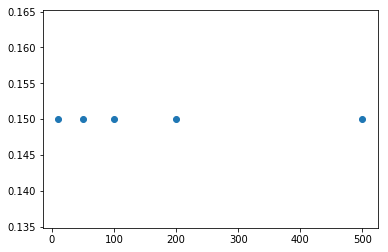

In [44]:
# [hw3-execruntest]
# TODO: Call runTest for n=10, 50, 100, 200, 500. 
# Store results in pageRankScores, and visualize the results.

n = [10,50,100,200,500]
#n = [10,50,100]
pageRankScores = []
#print(type(pageRankScores))
for i in n:
    pageRankScores.append(runTest(i,best_pages_df))

# pageRankScores
# pageRankScores.append(runTest(10,best_pages_df))
# print(pageRankScores)
    

plt.scatter(n, pageRankScores)

In [45]:
# [test-prscores-1]
# [CIS 545 Homework 3] Test Case
# Checking pagerankscores

if (pageRankScores[0] != pageRankScores[1]):
    raise ValueError('Incorrect value')

In [46]:
# [CIS 545 Test Cases] (0 pts)
print("[CIS 545 Homework 3] Test Case - 0 points")
score = score + 0

[CIS 545 Homework 3] Test Case - 0 points


In [47]:
# [test-prscores-2]
# [CIS 545 Homework 3] Test Case
# Checking pagerankscores values


In [48]:
# [CIS 545 Test Cases] (5 pts)
print("[CIS 545 Homework 3] Test Case - 5 points")
score = score + 5

[CIS 545 Homework 3] Test Case - 5 points


In [49]:
# [test-prscores-3]
# [CIS 545 Homework 3] Test Case
# Checking pagerankscores values


In [50]:
# [CIS 545 Test Cases] (5 pts)
print("[CIS 545 Homework 3] Test Case - 5 points")
score = score + 5

[CIS 545 Homework 3] Test Case - 5 points


### Effect of Adding Incoming Links from Other Pages (15 points)

Using the original `graph_df`, we will now add new __incoming edges__ to the target_page, and observe the difference in the page rank value of the target_page based on the *quantity* as well as *quality* of the incoming links.

### Step 2.5: Add incoming links from different subranges of `best_pages_df`

Implement a function `runTest2(n, best_pages_df)` that returns the PageRank value of the `target` page (i.e., node 5000) whose incoming links consist of the pages ranked between `n` and `n`+200 (inclusive) in `best_pages_df` and whose outgoing linkes are to the top 100 pages in `best_pages_df`.   The function should contain three steps:

1. Create an `edgeList` of outgoing links from the target page to the top 100 pages, and incoming links from pages ranked between `n` and `n`+200 (inclusive) to the target page.  Append `edgeList` to the original `graph_df`, creating a new dataframe of edges `graph_df2`.  Do not overwrite `graph_df`.
2. Using `graph_df2`, create the new weight transfer matrix `M`.  
3. Re-run `pagerank(M, 0.85, 15)` and return the PageRank value of the `target` page.

Thus, 100 outgoing edges and 200 incoming edges should be added in total for the target page in `graph_df2`.

In [51]:
# [hw3-runtest2]
# TODO: Create function runTest2(n, best_pages_df) that returns 
#     the PageRank value of the target page (node 5000) 
#     and calculates pagerank(M, 0.85, 15)
# (15 points)

def runTest2(n, best_pages_df):
    edgeList1=pd.DataFrame(best_pages_df.iloc[n:n+201]['id'])
    edgeList1.columns=['FromNodeId']
    edgeList1['ToNodeId']=5000
    #print(edgeList1)
    edgeList=pd.DataFrame(best_pages_df.iloc[:100]['id'])
    edgeList.columns=['ToNodeId']
    edgeList['FromNodeId']=5000
    edgeList.loc[:,['FromNodeId','ToNodeId']]
    #print(edgeList)
    edgeList=edgeList.append(edgeList1,sort=True)
#     print(edgeList)
    graph_df2=graph_df.append(edgeList)
    #print(graph_df2[graph_df2['FromNodeId']==14])
    weight_list = 1/graph_df2.groupby('FromNodeId').size()
    #print(weight_list)
    M=pd.DataFrame(np.zeros((5001,5001)), columns=range(0,5001), dtype=float)
    #print(M.iloc[5000,628])
    graph_df2.apply(lambda x: build_M(weight_list, M, x),axis=1)  
    #print(M.iloc[5000])
    pr = pagerank(M, 0.85, 25)
    return pr[-1][0] 

# p = runTest2(0, best_pages_df)
# p   

Run the above test for these values of `n` : [0,100,200,300,400,500,800,1000,2000,3000,4000,4500], store the output in an array `pageRankScores25` and create a scatter plot with the page rank scores of node 5000 for different values of `n`.

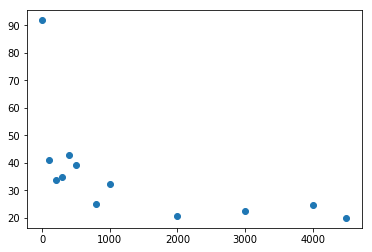

In [52]:
# [hw3-execruntest2]
# TODO: Call runTest2 for 
#     n = [0,100,200,300,400,500,800,1000,2000,3000,4000,4500]
#     and visualize the results.
#更多,更高的income page会导致更高的pagerank

# n = [0,20,40,60,80,100,150,200,250,300,350,400,450,500,600,700,800,900,1000,2000,3000,4000,4500]
n = [0,100,200,300,400,500,800,1000,2000,3000,4000,4500]
pageRankScores25 = []

for i in n:
    pageRankScores25.append(runTest2(i,best_pages_df))

# pageRankScores
# pageRankScores.append(runTest(10,best_pages_df))
# print(pageRankScores)
    

plt.scatter(n, pageRankScores25)

In [53]:
pageRankScores25

[91.89671908423409,
 40.95519591015964,
 33.61758679270681,
 34.88192104384606,
 42.663431810572966,
 39.27066421234756,
 24.88469317990259,
 32.39714842311562,
 20.486708256969255,
 22.473546784003585,
 24.56443895744115,
 19.949234864206236]

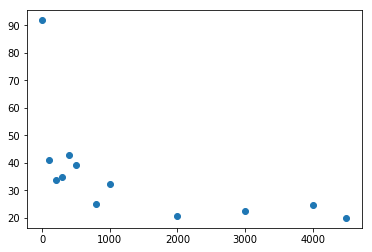

In [54]:
# [hw3-plot]
# Plot the result

plt.scatter(n, pageRankScores25)

In [55]:
# [hw3-padding]
# Just a padding cell

print("[CIS 545 Homework 3] Padding")

[CIS 545 Homework 3] Padding


You can observe that incoming links from **more influential pages** adds more value to your page and increases its importance as perceived by the page rank.

In [56]:
# [test-prscores-4]
# [CIS 545 Homework 3] Test Case
# Checking pagerankscores values for runtest2

if ((sum(pageRankScores25[:5])- 244.01) > 0.01):
    raise ValueError('Incorrect values')

In [57]:
# [CIS 545 Test Cases] (0 pts)
print("[CIS 545 Homework 3] Test Case - 0 points")
score = score + 0

[CIS 545 Homework 3] Test Case - 0 points


In [58]:
# [test-prscores-5]
# [CIS 545 Homework 3] Test Case
# Checking pagerankscores values for runtest2


In [59]:
# [CIS 545 Test Cases] (5 pts)
print("[CIS 545 Homework 3] Test Case - 5 points")
score = score + 5

[CIS 545 Homework 3] Test Case - 5 points


In [60]:
# [test-prscores-6]
# [CIS 545 Homework 3] Test Case
# Checking pagerankscores values for runtest2


In [61]:
# [CIS 545 Test Cases] (5 pts)
print("[CIS 545 Homework 3] Test Case - 5 points")
score = score + 5

[CIS 545 Homework 3] Test Case - 5 points


In [62]:
# [test-prscores-7]
# [CIS 545 Homework 3] Test Case
# Checking pagerankscores values for runtest2


In [63]:
# [CIS 545 Test Cases] (5 pts)
print("[CIS 545 Homework 3] Test Case - 5 points")
score = score + 5

[CIS 545 Homework 3] Test Case - 5 points


### Understanding Connectivity (10 points)
A key takeway from this is that it is not sufficient to have incoming links from influential pages. Although there is a general trend that having incoming links from influential pages increases your page rank, what also matters is whether there is **connectivity** between the nodes that the target_page is linking to and is receiving links from.

We can observe this by changing the list of nodes that the target_page has outgoing links to and observe the change in its page rank value. Instead of the target_page having outgoing links to pages 0-100, we will make it have outgoing links to pages 500-600. You will be able to observe the bump in the page rank value of target_page when it has incoming links from these same set of pages.

### Step 2.6  Effect of overlap in incoming and outgoing links
For this task, you need to implement a function `runTest3(n, best_pages_df)` that modifies `runTest2()` to have outgoing links to pages 500-600, and again returns the page rank value of the target page (i.e., node 5000).

1. Create an `edgeList` of outgoing links from the target page to pages 500-600, and incoming links from pages ranked between `n` and `n`+200 (inclusive) to the target page.  Append `edgeList` to the original `graph_df`, creating a new dataframe of edges `graph_df2`.  Do not overwrite `graph_df`.
2. Using `graph_df2`, create the new weight transfer matrix `M`.  
3. Re-run `pagerank(M, 0.85, 15)` and return the PageRank value of the `target` page.

Again, 100 outgoing edges and 200 incoming edges should be added in total for the target page in `graph_df2`.

In [64]:
# [hw3-runtest3]
# TODO: Create function runTest3(n, best_pages_df) in which 
#     the target page has outgoing links to pages 500-600 
#     and incoming links from pages n to n+200.
#     Return the PageRank value of the target page.
# (5 points)

def runTest3(n, best_pages_df): 
    edgeList1=pd.DataFrame(best_pages_df.iloc[n:n+201]['id'])
    edgeList1.columns=['FromNodeId']
    edgeList1['ToNodeId']=5000
    edgeList=pd.DataFrame(best_pages_df.iloc[500:601]['id'])
    edgeList.columns=['ToNodeId']
    edgeList['FromNodeId']=5000
    edgeList.loc[:,['FromNodeId','ToNodeId']]
    edgeList=edgeList.append(edgeList1,sort=True)
    graph_df2=graph_df.append(edgeList)
    weight_list = 1/graph_df2.groupby('FromNodeId').size()
    print(weight_list)
    M=pd.DataFrame(np.zeros((5001,5001)), columns=range(0,5001), dtype=float)
    graph_df2.apply(lambda x: build_M(weight_list, M, x),axis=1)  
    pr = pagerank(M, 0.85, 25)
    return pr[-1][0] 
    

Run the above test for these values of `n` : [0,100,200,300,400,500,800,1000,2000,3000,4000,4500], store the output in an array called `pageRankScores26` and create a scatter plot with the PageRank scores of node 5000 for different values of these incoming links.

FromNodeId
0       0.055556
1       0.038462
2       1.000000
3       0.142857
4       0.022727
5       0.125000
6       0.024390
7       0.024390
8       0.076923
9       0.055556
10      0.012821
11      0.017857
12      0.333333
13      0.333333
14      0.500000
15      0.071429
16      0.083333
17      0.090909
18      0.250000
19      0.010526
20      0.004132
21      0.076923
22      0.500000
23      0.066667
24      0.066667
25      0.037037
26      0.090909
27      0.071429
28      1.000000
29      0.058824
          ...   
4971    0.500000
4972    0.500000
4973    0.500000
4974    0.500000
4975    0.500000
4976    0.500000
4977    0.500000
4978    0.500000
4979    0.500000
4980    0.500000
4981    0.500000
4982    0.500000
4983    0.500000
4984    0.500000
4985    0.500000
4986    0.500000
4987    0.500000
4988    0.500000
4989    0.500000
4990    0.500000
4991    0.500000
4992    0.500000
4993    0.500000
4994    0.500000
4995    0.500000
4996    0.500000
4997    0.500000
499

FromNodeId
0       0.058824
1       0.040000
3       0.166667
4       0.023256
5       0.142857
6       0.025000
7       0.025000
8       0.083333
9       0.058824
10      0.012987
11      0.018182
12      0.500000
13      0.500000
14      1.000000
15      0.076923
16      0.090909
17      0.100000
18      0.333333
19      0.010638
20      0.004149
21      0.083333
22      0.500000
23      0.071429
24      0.071429
25      0.038462
26      0.090909
27      0.076923
28      1.000000
29      0.062500
30      0.200000
          ...   
4971    0.500000
4972    0.500000
4973    0.500000
4974    0.500000
4975    0.500000
4976    0.500000
4977    0.500000
4978    0.500000
4979    0.500000
4980    0.500000
4981    0.500000
4982    0.500000
4983    0.500000
4984    0.500000
4985    0.500000
4986    0.500000
4987    0.500000
4988    0.500000
4989    0.500000
4990    0.500000
4991    0.500000
4992    0.500000
4993    0.500000
4994    0.500000
4995    0.500000
4996    0.500000
4997    0.500000
499

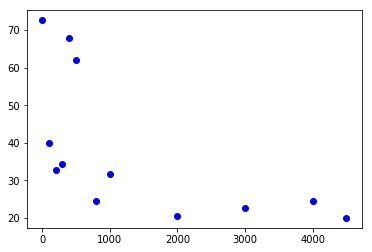

In [65]:
# [hw3-execruntest3]
# TODO: Call runTest3 for n = [0,100,200,300,400,500,800,1000,2000,3000,4000,4500]
# and visualize the results.
# (5 points)

n = [0,100,200,300,400,500,800,1000,2000,3000,4000,4500]
#n = [0,100,200,300,350,400,450,500,550,600,700,800,900,1000]
pageRankScores26 = []

for i in n:
    pageRankScores26.append(runTest3(i,best_pages_df))

plt.plot(n,pageRankScores26,'bo') 

In [ ]:
pageRankScores26

In [66]:
if (np.abs(pageRankScores26[0] - 72.64) > 0.01) :
    raise ValueError('Incorrect value')

In [67]:
# [test-prscores-8]
# [CIS 545 Homework 3] Test Case
# Checking pagerankscores values for runtest3

if ((sum(pageRankScores26[:5])- 247.43) > 0.01):
    raise ValueError('Incorrect values')

In [ ]:
# [CIS 545 Test Cases] (0 pts)
print("[CIS 545 Homework 3] Test Case - 0 points")
score = score + 0

In [ ]:
# [test-prscores-9]
# [CIS 545 Homework 3] Test Case
# Checking pagerankscores values for runtest3


In [ ]:
# [CIS 545 Test Cases] (5 pts)
print("[CIS 545 Homework 3] Test Case - 5 points")
score = score + 5

In [ ]:
# [test-prscores-10]
# [CIS 545 Homework 3] Test Case
# Checking pagerankscores values for runtest3


In [ ]:
# [CIS 545 Test Cases] (5 pts)
print("[CIS 545 Homework 3] Test Case - 5 points")
score = score + 5

### Visualizing the Effect (5 points)

To get a better understanding of the effect of adding different kinds of links from and to the target page, we plot the values from `pageRankScores25` and `pageRankScores26` in the same plot and compare the differences in the values as we move from 0 to 4500. 

For a better visualization, make sure to represent the data points by dots and join these data points using lines. This can be done using the following command `plt.plot(x,y,'r-o')`. The third argument to plot can be intrepreted as follows : `r` plots the points in red color, `-` adds straight lines between data points and `o` marks data points as dots.

In [ ]:
# [hw3-pyplot]
# Create object 'graph' as described above
import matplotlib.pyplot as plt
# from matplotlib.legend_handler import HandlerLine2D

#graph = '' # Base - you may delete this if it works better with your code (i.e. you do the plot differently!)

line1, = plt.plot(n,pageRankScores25,color='blue',marker='o',label='pageRankScores25')
line2, = plt.plot(n,pageRankScores26,color='red',marker='o',label='pageRankScores26')
plt.legend()
plt.show()

In [ ]:
# [hw3-testgraph]
# Hidden tests for your graph


In [ ]:
# [CIS 545 Test Cases] (5 pts)
print("[CIS 545 Homework 3] Test Case - 5 points")
score = score + 5